In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [2]:
# Set device (GPU 1)
torch.cuda.set_device(1)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
#Parameters
img_rows, img_cols = 224, 224
batch_size = 64
n_epochs = 10

In [4]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((img_rows, img_cols)),
    transforms.ToTensor()
])

In [5]:
#Directory
data_dir = r"C:\Users\RTX2080Ti\Desktop\MSTC Conference\All img"
full_dataset = datasets.ImageFolder(os.path.join(data_dir), transform=transform)

In [6]:
# Data split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [7]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
#CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64 * (img_rows // 4) * (img_cols // 4), 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [9]:
# Instantiate model
model = CNNModel().to(device)

In [10]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # ---- Validation ----
    model.eval()
    val_running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Collect predictions
            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    epoch_val_loss = val_running_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    # Compute metrics for validation
    binary_preds = [1 if p > 0.5 else 0 for p in all_preds]
    acc = accuracy_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {acc:.4f} | "
          f"AUC: {roc_auc:.4f} | F1: {f1:.4f}")

Epoch 1/10 | Train Loss: 0.4804 | Val Loss: 0.0513 | Val Acc: 0.9611 | AUC: 0.9978 | F1: 0.9604
Epoch 2/10 | Train Loss: 0.1560 | Val Loss: 0.0235 | Val Acc: 0.9989 | AUC: 0.9997 | F1: 0.9990
Epoch 3/10 | Train Loss: 0.1142 | Val Loss: 0.0165 | Val Acc: 0.9990 | AUC: 1.0000 | F1: 0.9990
Epoch 4/10 | Train Loss: 0.0979 | Val Loss: 0.0108 | Val Acc: 0.9996 | AUC: 1.0000 | F1: 0.9996
Epoch 5/10 | Train Loss: 0.1010 | Val Loss: 0.0094 | Val Acc: 0.9999 | AUC: 1.0000 | F1: 0.9999
Epoch 6/10 | Train Loss: 0.0913 | Val Loss: 0.0097 | Val Acc: 0.9993 | AUC: 1.0000 | F1: 0.9993
Epoch 7/10 | Train Loss: 0.0875 | Val Loss: 0.0083 | Val Acc: 0.9995 | AUC: 1.0000 | F1: 0.9995
Epoch 8/10 | Train Loss: 0.0870 | Val Loss: 0.0120 | Val Acc: 0.9995 | AUC: 1.0000 | F1: 0.9996
Epoch 9/10 | Train Loss: 0.0845 | Val Loss: 0.0075 | Val Acc: 0.9996 | AUC: 1.0000 | F1: 0.9996
Epoch 10/10 | Train Loss: 0.1006 | Val Loss: 0.0079 | Val Acc: 0.9997 | AUC: 1.0000 | F1: 0.9997


In [12]:
# Results Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).cpu().numpy().flatten()
        all_preds.extend(outputs)
        all_labels.extend(labels.cpu().numpy().flatten())

binary_preds = [1 if p > 0.5 else 0 for p in all_preds]

# Compute metrics
acc = accuracy_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

print("\nFinal Validation Results:")
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")


Final Validation Results:
Accuracy: 0.9997
AUC: 1.0000
F1 Score: 0.9997


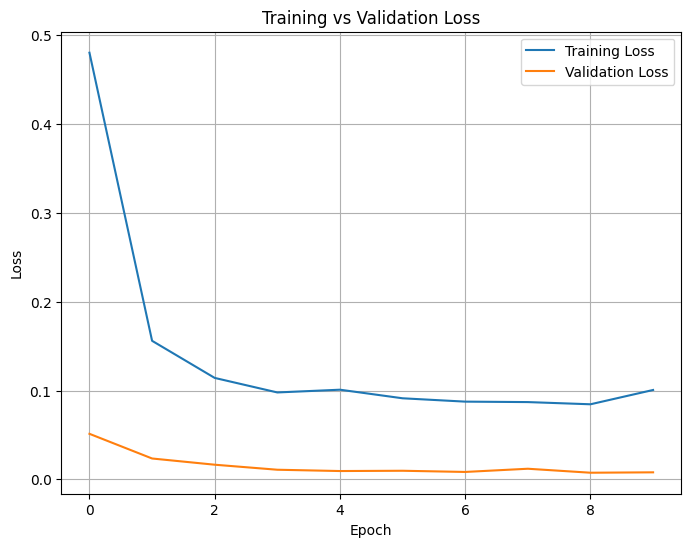

In [13]:
# ---- Plotting Loss Curves ----
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

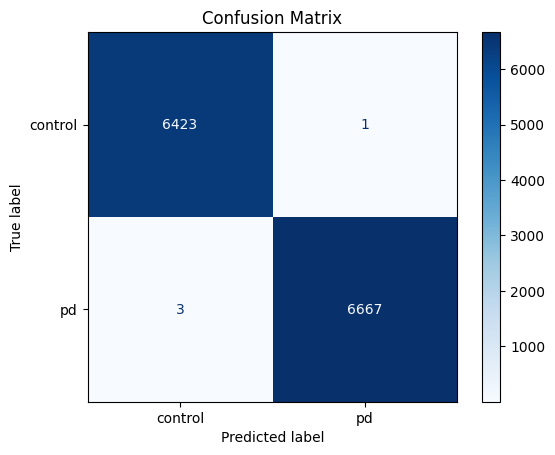

In [15]:
# Plot Confusion Matrix
cm = confusion_matrix(all_labels, binary_preds)

# Use the original dataset (ImageFolder) to get class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_dataset.classes)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [18]:
from sklearn.metrics import precision_score, recall_score, classification_report

# Precision and Recall
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, binary_preds, target_names=full_dataset.classes))

Precision: 0.9999
Recall: 0.9996

Classification Report:
              precision    recall  f1-score   support

     control       1.00      1.00      1.00      6424
          pd       1.00      1.00      1.00      6670

    accuracy                           1.00     13094
   macro avg       1.00      1.00      1.00     13094
weighted avg       1.00      1.00      1.00     13094



In [17]:
torch.save(model.state_dict(), 'model.pth')